In [510]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from PIL import Image
from torch.autograd import Variable

In [511]:
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  #convert to black and white
    transforms.Resize((50, 200)),  # rescale
    transforms.ToTensor(),       
    transforms.Normalize([0.5], [0.5])  #normalize
])

#because the image title is what the class is defined as, we need a special function
#to extract the class from the image title and make a tensor out of it
all_classes = []
class CustomImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = [os.path.join(root_dir, fname) for fname in os.listdir(root_dir) if fname.endswith(('.png', '.jpg', '.jpeg'))]

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path)
        if self.transform:
            image = self.transform(image)
        #get the image title without the .png
        label = os.path.splitext(os.path.basename(img_path))[0]
        all_classes.append(label) #just want to see all the classes
        #convert to tensor
        label_tensor = torch.tensor([ord(char) for char in label], dtype=torch.long)

        return image, label_tensor[4] #the number here represents what letter we are training the model on

# make dataset
dataset = CustomImageDataset(root_dir=os.path.expanduser('~/Downloads/captcha_project/captcha'), transform=transform)

dataloader = DataLoader(dataset, batch_size=64, shuffle=True)


In [512]:
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

torch.manual_seed(42)

#split the datasets with 80/20 train and testing
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

#get test_indices
test_indices = test_dataset.indices



In [513]:
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        #make 3 layers
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=12, kernel_size=5, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(12)
        self.conv2 = nn.Conv2d(in_channels=12, out_channels=12, kernel_size=5, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(12)
        self.pool = nn.MaxPool2d(2,2)
        self.conv4 = nn.Conv2d(in_channels=12, out_channels=24, kernel_size=5, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(24)
        self.conv5 = nn.Conv2d(in_channels=24, out_channels=24, kernel_size=5, stride=1, padding=1)
        self.bn5 = nn.BatchNorm2d(24)
        self.fc1 = nn.Linear(24 * 47 * 9, 128)  # 128 total possible ascii characters

    def forward(self, input):
        output = F.relu(self.bn1(self.conv1(input)))
        
        output = F.relu(self.bn2(self.conv2(output)))
        
        output = self.pool(output)
        
        output = F.relu(self.bn4(self.conv4(output)))
        
        output = F.relu(self.bn5(self.conv5(output)))
        
        output = self.pool(output)
        
        output = output.view(-1, 24 * 47 * 9)  #needs to match output
        
        output = self.fc1(output)
        
        return output
#make the model
model = Network()

In [514]:
from torch.optim import Adam
#loss function and optimizer 
loss_fn = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=0.001, weight_decay=0.0001)

In [515]:
def saveModel():
    downloads_path = os.path.expanduser("~/Downloads/captcha_project/myFifthModel.pth")
    torch.save(model.state_dict(), downloads_path)
    if os.path.exists(downloads_path):
        print(f"Model successfully saved to {downloads_path}")
    else:
        print(f"Failed to save the model to {downloads_path}")

#the test_loader (ie the items we test with) is not saved in the model. So need to also save this
def save_test_loader_data(test_loader, model_name):
    all_images = []
    all_labels = []
    all_indices = []
    
    for batch_idx, (images, labels) in enumerate(test_loader):
        all_images.extend(images.numpy())
        all_labels.extend(labels.numpy())
        all_indices.extend([batch_idx * test_loader.batch_size + i for i in range(len(images))])
    
    #make directory to save it
    model_dir = os.path.expanduser(f"~/Downloads/captcha_project/{model_name}")
    os.makedirs(model_dir, exist_ok=True)
    
    # Save images, labels, and indices
    torch.save(all_images, os.path.join(model_dir, 'test_images.pt'))
    torch.save(all_labels, os.path.join(model_dir, 'test_labels.pt'))
    torch.save(all_indices, os.path.join(model_dir, 'test_indices.pt'))
    print(f"Test loader data successfully saved to {model_dir}")

def testAccuracy():
    model.eval()
    accuracy = 0.0
    total = 0.0
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            #run the model
            outputs = model(images.to(device))
            # the label with the highest energy will be our prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            accuracy += (predicted == labels.to(device)).sum().item()
    
    accuracy = (100 * accuracy / total)
    return(accuracy)


In [516]:
def train(num_epochs):
    
    best_accuracy = 0.0
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("The model will be running on", device, "device")

    model.to(device)

    for epoch in range(num_epochs):  #epoch loop
        running_loss = 0.0
        running_acc = 0.0

        for i, (images, labels) in enumerate(train_loader, 0):
            
            #inputs
            images = Variable(images.to(device))
            labels = Variable(labels.to(device))

            #set optimizer to zero
            optimizer.zero_grad()
            #run the model
            outputs = model(images)
            #find loss
            loss = loss_fn(outputs, labels)
            #backpropogate
            loss.backward()
            #move optimizer
            optimizer.step()

            #print loss for every 1000 photos
            running_loss += loss.item()
            if i % 1000 == 999:    
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / 1000))
                # zero the running_loss
                running_loss = 0.0

        accuracy = testAccuracy()
        print('For epoch', epoch+1,'the test accuracy over the whole test set is %d %%' % (accuracy))

        #save model if accuracy is better
        if accuracy > best_accuracy:
            saveModel()
            best_accuracy = accuracy

In [517]:
import matplotlib.pyplot as plt
import numpy as np

def imageshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [518]:
# Function to test what classes performed well
def testClassess():
    class_correct = list(0. for i in range(number_of_labels))
    class_total = list(0. for i in range(number_of_labels))
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            c = (predicted == labels).squeeze()
            for i in range(batch_size):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1

    for i in range(number_of_labels):
        print('Accuracy of %5s : %2d %%' % (
            classes[i], 100 * class_correct[i] / class_total[i]))

In [519]:
#MODEL TIME YAYAYAY
train(5)
print('Finished Training')

The model will be running on cpu device
For epoch 1 the test accuracy over the whole test set is 23 %
Model successfully saved to /Users/magnustangherlini/Downloads/captcha_project/myFifthModel.pth
For epoch 2 the test accuracy over the whole test set is 45 %
Model successfully saved to /Users/magnustangherlini/Downloads/captcha_project/myFifthModel.pth
For epoch 3 the test accuracy over the whole test set is 57 %
Model successfully saved to /Users/magnustangherlini/Downloads/captcha_project/myFifthModel.pth
For epoch 4 the test accuracy over the whole test set is 69 %
Model successfully saved to /Users/magnustangherlini/Downloads/captcha_project/myFifthModel.pth
For epoch 5 the test accuracy over the whole test set is 67 %
Finished Training


In [520]:
#save the test_loader before we forget lol
save_test_loader_data(test_loader, "myFifthModel")

Test loader data successfully saved to /Users/magnustangherlini/Downloads/captcha_project/myFifthModel


In [521]:

#visualize the image
def imshow(img, title):
    img = img / 2 + 0.5  # Unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)), cmap='gray')
    plt.title(title)
    plt.show()

Image dimensions: 200x50 pixels


/var/folders/7_/5fn5htf54wn_m3yp89hpzn_r0000gn/T/ipykernel_75631/3403232193.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(path))


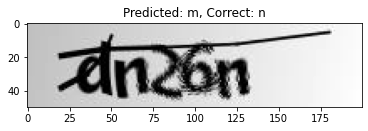

Predicted: m, Correct: n


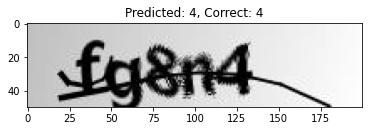

Predicted: 4, Correct: 4


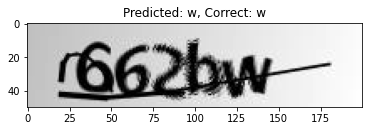

Predicted: w, Correct: w


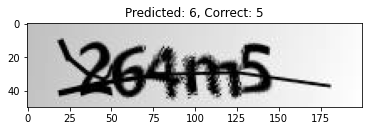

Predicted: 6, Correct: 5


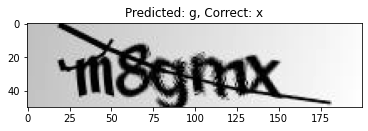

Predicted: g, Correct: x


In [522]:
model = Network()
path = os.path.expanduser("~/Downloads/captcha_project/myFifthModel.pth")
model.load_state_dict(torch.load(path))
model.eval()  # Set the model to evaluation mode
dataiter = iter(test_loader)
images, labels = next(dataiter)
print(f"Image dimensions: {images[0].shape[2]}x{images[0].shape[1]} pixels")
# Make predictions
with torch.no_grad():
    outputs = model(images)
    _, predicted = torch.max(outputs, 1)


# Display the first 5 images, their predictions, and indices
for i in range(5):
    correct_label = chr(labels[i].item())
    predicted_label = chr(predicted[i].item())
    imshow(images[i], f'Predicted: {predicted_label}, Correct: {correct_label}')
    print(f"Predicted: {predicted_label}, Correct: {correct_label}")

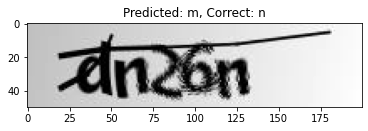

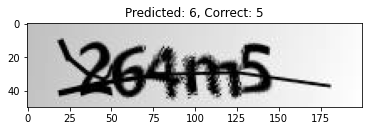

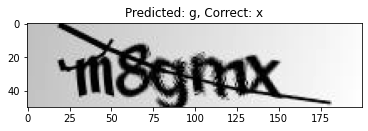

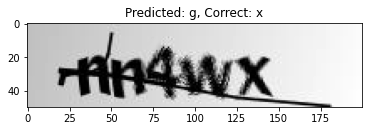

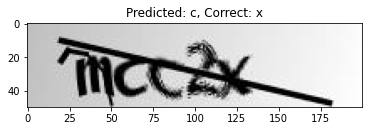

In [523]:
misclassified_images = []
misclassified_labels = []
misclassified_predictions = []

with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        for i in range(len(labels)):
            if predicted[i] != labels[i]:
                misclassified_images.append(images[i])
                misclassified_labels.append(labels[i])
                misclassified_predictions.append(predicted[i])


#show 5 images
for i in range(min(5, len(misclassified_images))):
    correct_label = chr(misclassified_labels[i].item())
    predicted_label = chr(misclassified_predictions[i].item())
    imshow(misclassified_images[i], f'Predicted: {predicted_label}, Correct: {correct_label}')

In [524]:
#lets get the prediction, label, image, and what index the photo is from each model
def evaluate_model(model, test_loader, device):
    model.eval()
    all_predictions = []
    all_labels = []
    all_images = []
    all_indices = []
    
    with torch.no_grad():
        for batch_idx, (images, labels) in enumerate(test_loader):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_images.extend(images.cpu())
            all_indices.extend([batch_idx * test_loader.batch_size + i for i in range(len(images))])
    
    return all_predictions, all_labels, all_images, all_indices

/var/folders/7_/5fn5htf54wn_m3yp89hpzn_r0000gn/T/ipykernel_75631/382688716.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.expa

Evaluating model 1
Evaluating model 2
Evaluating model 3
Evaluating model 4
Evaluating model 5


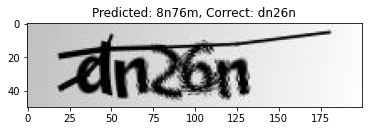

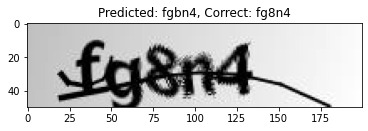

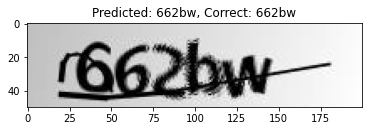

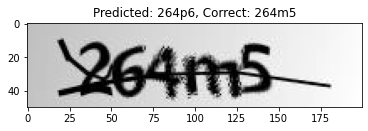

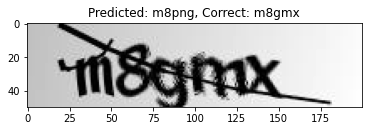

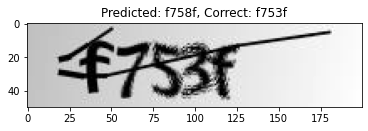

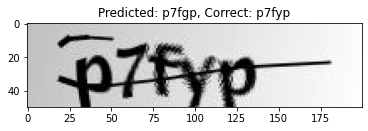

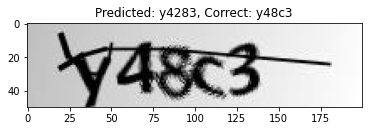

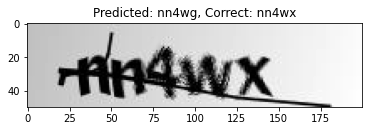

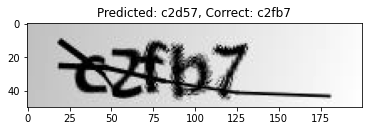

In [525]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_paths = [
    "~/Downloads/captcha_project/myFirstModel.pth",
    "~/Downloads/captcha_project/mySecondModel.pth",
    "~/Downloads/captcha_project/myThirdModel.pth",
    "~/Downloads/captcha_project/myFourthModel.pth",
    "~/Downloads/captcha_project/myFifthModel.pth"
]

models = []
for model_path in model_paths:
    model = Network().to(device)
    model.load_state_dict(torch.load(os.path.expanduser(model_path)))
    models.append(model)



test_loader_paths = [
    "~/Downloads/captcha_project/myFirstModel/test_labels.pt",
    "~/Downloads/captcha_project/mySecondModel/test_labels.pt",
    "~/Downloads/captcha_project/myThirdModel/test_labels.pt",
    "~/Downloads/captcha_project/myFourthModel/test_labels.pt",
    "~/Downloads/captcha_project/myFifthModel/test_labels.pt"
]

# Function to load labels from the specified paths
def load_labels(paths):
    labels_list = []
    for path in paths:
        expanded_path = os.path.expanduser(path)
        labels = torch.load(expanded_path)
        labels_list.append(labels)
    return labels_list

#get all the labels in all their different lists
labels_list = load_labels(test_loader_paths)

#the labels_list is a 5 lists with characters. The first item refers to the first label, etc.
#this list comprehension iterates across the first elem of each list, concatenates those, then goes to the second item
concatenated_correct = [''.join(chr(label[i]) for label in labels_list) for i in range(len(labels_list[0]))]

all_model_predictions = []
all_labels = None
all_images = None
all_indices = None
for i, model in enumerate(models):
    print(f"Evaluating model {i+1}")
    predictions, labels, images, indices = evaluate_model(model, test_loader, device)
    all_model_predictions.append(predictions)
    all_labels = labels  #save labels
    all_images = images  #save images
    all_indices = indices  #save indices

#convert predictions from ascii to characters
if isinstance(all_labels[0], np.int64):
    all_labels = [[label] for label in all_labels]

concatenated_predictions = [''.join(chr(pred[i]) for pred in all_model_predictions) for i in range(len(all_model_predictions[0]))]

for i, img in enumerate(all_images[:10]):
    title = f"Predicted: {concatenated_predictions[i]}, Correct: {concatenated_correct[i]}"
    imshow(img, title)

In [527]:
import Levenshtein

total_edit_distance = 0
for i in range(len(concatenated_predictions)):
    total_edit_distance += Levenshtein.distance(concatenated_predictions[i], concatenated_correct[i])
print(f"Total Levenshtein Edit Distance: {total_edit_distance}")

#calculate the error
error = total_edit_distance / (len(concatenated_predictions)*len(concatenated_predictions[0]))
print(f"Error rate: {error}")

Total Levenshtein Edit Distance: 260
Error rate: 0.24299065420560748
